In [16]:
# LIBRARY:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

import statsmodels as sa

plt.rcParams['pdf.fonttype'] = 42

%matplotlib inline
%matplotlib nbagg

%cd /Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES/

/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/bb_test_results/qvalues/GTEX-ALL_SAMPLES


In [2]:
# Import dataset:

df = pd.read_csv('GTEX-ALL_SAMPLES.v8.phASER.gw_phased.results.fdr_ALL.gene_info.zscores.txt', sep='\t')

# add column for GENE_IDs without version #:
df[['GENE_ID','ens_version']] = df['GENE_ID'].str.split('.',expand=True)

df.head()

/Users/snkravitz/opt/miniconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,CHR,GENE_ID,GENE_NAME,gene_start,gene_stop,SUBJECT_ID,tissue_num,data_pvalues,data_qvalues,data_lfdr,mean_read_counts,total_sample_count_females,total_sample_count_males,total_sample_count,count_fdr_0p1,daee_pctile_fdr_0p1,z_score,RME_effect,ens_version
0,1,ENSG00000228794,LINC01128,825137,859446,GTEX-SE5C,14.0,0.233974,0.655684,1.0,58.0,133.0,NaN,414,74.0,0.178744,0.315991,private_RME,8
1,1,ENSG00000223764,RP11-54O7.3,916869,919692,GTEX-SE5C,10.0,1.000000,1.000000,1.0,38.0,173.0,NaN,492,132.0,0.268293,0.915775,private_RME,2
2,1,ENSG00000188976,NOC2L,944581,959309,GTEX-SE5C,17.0,1.000000,1.000000,1.0,178.0,179.0,NaN,532,48.0,0.090226,-0.276891,private_RME,10
3,1,ENSG00000187961,KLHL17,960586,965715,GTEX-SE5C,15.0,0.473719,1.000000,1.0,24.0,160.0,NaN,473,34.0,0.071882,-0.399756,private_RME,13
4,1,ENSG00000187583,PLEKHN1,966496,975108,GTEX-SE5C,7.0,0.525752,1.000000,1.0,96.0,194.0,NaN,566,47.0,0.083039,-0.325026,private_RME,10


In [3]:
## Filter out X-Chr genes, Imprinted genes, and HLA genes:

# Remove X-Chr:
df = df[df['CHR'] != 'X']

# Remove HLA genes:
df = df[~df['GENE_NAME'].str.contains("HLA")]

# Remove Imprinted Genes:
imprinted_df = pd.read_csv("~/Documents/Gene_Lists/GTEx_Imprinting/GTEx_Imprinted_Table_S3andS4.uniq.txt", sep=' ', names=['GENE_ID', 'chrom', 'start'])
imprinted_genes = list(imprinted_df['GENE_ID'])
imprinted_genes
df = df[~df['GENE_ID'].isin(imprinted_genes)]

In [4]:
# Drop duplicate rows:

df = df[['CHR', 'GENE_ID', 'GENE_NAME', 'z_score']].dropna().drop_duplicates(subset=['GENE_ID'])

df.shape

(23481, 4)

In [5]:
df.head()

,CHR,GENE_ID,GENE_NAME,z_score
0,1,ENSG00000228794,LINC01128,0.315991
1,1,ENSG00000223764,RP11-54O7.3,0.915775
2,1,ENSG00000188976,NOC2L,-0.276891
3,1,ENSG00000187961,KLHL17,-0.399756
4,1,ENSG00000187583,PLEKHN1,-0.325026


In [5]:
## Get median SNP # per Gene:

df_snps = pd.read_csv('/Users/snkravitz/Documents/Projects_and_Data/GTEx_HaplotypeExpression/GTEX-ALL_SAMPLES.v8.wasp_corrected.ase_table.median_SNPcounts_per_gene.txt.gz', compression='gzip', sep='\t')
df_snps.head()


,CHR,GENE_ID,VARIANT_ID
0,chr1,ENSG00000000457,12
1,chr1,ENSG00000000460,2
2,chr1,ENSG00000000938,2
3,chr1,ENSG00000000971,34
4,chr1,ENSG00000001460,4


In [6]:
# Merge Z-score to median # of SNPs per gene:

df_snp_meds = df_snps.merge(df[['GENE_ID', 'z_score']], how='inner', on='GENE_ID')
df_snp_meds.head()

,CHR,GENE_ID,VARIANT_ID,z_score
0,chr1,ENSG00000000457,12,-0.149095
1,chr1,ENSG00000000460,2,1.860492
2,chr1,ENSG00000000938,2,-0.729558
3,chr1,ENSG00000000971,34,2.340941
4,chr1,ENSG00000001460,4,-0.198625


In [7]:
## Get number of SNPs per gene NORMALIZED by gene length: 

## Get gene length info from GTF file:
gene_length = pd.read_csv("../QC_SupplementalFigures/gencode.v26.GRCh38.genes.gtf.genelength", sep='\t')

# add column for GENE_IDs without version #:
gene_length[['GENE_ID','ens_version']] = gene_length['gene'].str.split('.',expand=True)

gene_length.head()

,gene,mean,median,longest_isoform,merged,GENE_ID,ens_version
0,ENSG00000242268.2,710,710,710,710,ENSG00000242268,2
1,ENSG00000188026.12,3756,3756,3756,3756,ENSG00000188026,12
2,ENSG00000270112.3,4685,4685,4685,4685,ENSG00000270112,3
3,ENSG00000280143.1,3308,3308,3308,3308,ENSG00000280143,1
4,ENSG00000269416.5,3296,3296,3296,3296,ENSG00000269416,5


In [10]:
## Get number of SNPs per gene NORMALIZED by gene length (cont.): 

## Merge gene length to original dataframe:
#df_snp_meds = df_snp_meds.merge(gene_length[['GENE_ID', 'longest_isoform']], how='left', on='GENE_ID')
#df_snp_meds = df_snp_meds[['GENE_ID', 'VARIANT_ID', 'z_score', 'longest_isoform']].drop_duplicates()
#df_snp_meds.head()


## Get number of SNPs normalized per kilobase of gene length: 
df_snp_meds['snps_per_geneLength'] = (df_snp_meds['VARIANT_ID'] / df_snp_meds['longest_isoform']) * 1000 
df_snp_meds.head()



,GENE_ID,VARIANT_ID,z_score,longest_isoform,snps_per_geneLength
0,ENSG00000000457,12,-0.149095,5586,2.148228
1,ENSG00000000460,2,1.860492,4579,0.436777
2,ENSG00000000938,2,-0.729558,3474,0.575705
3,ENSG00000000971,34,2.340941,4620,7.359307
4,ENSG00000001460,4,-0.198625,8400,0.476190


<IPython.core.display.Javascript object>


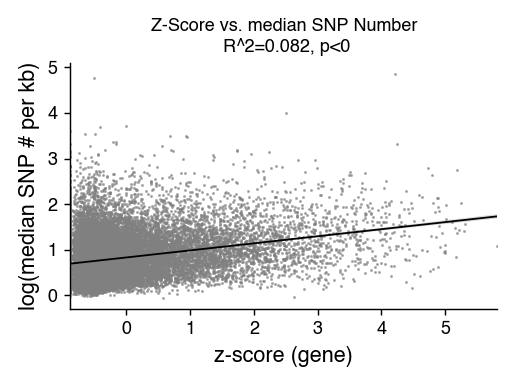

In [17]:
f, ax = plt.subplots(figsize=(4,3), tight_layout=True)
sns.despine()

slope, intercept, r_value, p_value, std_err = stats.linregress(df_snp_meds['z_score'],np.log1p(df_snp_meds['snps_per_geneLength']))
r_squared = r_value ** 2

ax = sns.regplot(data=df_snp_meds, x=df_snp_meds['z_score'], y=np.log1p(df_snp_meds['snps_per_geneLength']), fit_reg=True, truncate=True, ci=95, scatter_kws={"color":"grey", "s": 0.5, "alpha": 0.6, 'rasterized': True}, line_kws={"color":"black", "lw":1}, y_jitter=0.1)
#ax.set_ylim(0,80)
ax.set_xlabel('z-score (gene)', fontsize=12, fontweight='light')
ax.set_ylabel('log(median SNP # per kb)', fontsize=12, fontweight='light')
ax.set_title('Z-Score vs. median SNP Number\n R^2={0:.2g}, p<{1:.2g}'.format(r_squared,p_value), fontsize=10)
#ax.text(4, 6, "r={0:.1f}, p={1:.1f}".format(r_value,p_value), horizontalalignment='left', size='medium', color='black') #, weight='semibold')
#ax.legend()

#f.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.medSNPnum.vs.z-score_regplot.perGeneLength.pdf', dpi=400, transparent=True)


In [18]:
## Subset RME and Biallelic genes (and 'Unknown'):

df_snp_meds['mosaic_category'] = np.where(df_snp_meds['z_score'] >= 0.74, 'RME', 'Unknown')
df_snp_meds['mosaic_category'] = np.where(df_snp_meds['z_score'] < 0, 'Biallelic', df_snp_meds['mosaic_category'])

df_snp_meds.head()

,GENE_ID,VARIANT_ID,z_score,longest_isoform,snps_per_geneLength,mosaic_category
0,ENSG00000000457,12,-0.149095,5586,2.148228,Biallelic
1,ENSG00000000460,2,1.860492,4579,0.436777,RME
2,ENSG00000000938,2,-0.729558,3474,0.575705,Biallelic
3,ENSG00000000971,34,2.340941,4620,7.359307,RME
4,ENSG00000001460,4,-0.198625,8400,0.476190,Biallelic


<IPython.core.display.Javascript object>


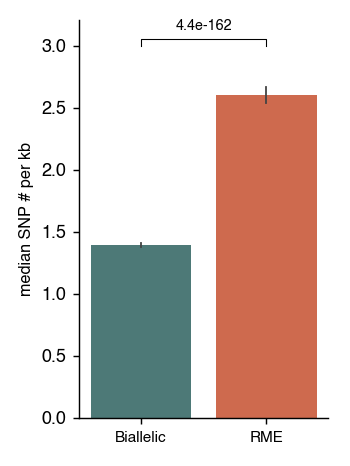

In [34]:
## Plot boxplot of Biallelic vs. RME genes for median TPMs:

f, ax = plt.subplots(figsize=(1.5, 2), tight_layout=True)
sns.despine()

f_oneway = stats.f_oneway(df_snp_meds[df_snp_meds['mosaic_category'] == 'Biallelic']['snps_per_geneLength'], df_snp_meds[df_snp_meds['mosaic_category'] == 'RME']['snps_per_geneLength'])


ax = sns.barplot(x=df_snp_meds['mosaic_category'], y=df_snp_meds['snps_per_geneLength'], data=df_snp_meds[df_snp_meds['mosaic_category'] != 'Unknown'], order=["Biallelic", "RME"], palette=["#46807D","#E35E39"], ci=68, errwidth=1)
ax.plot([0, 0, 1, 1], [3, 3.05, 3.05, 3], lw=0.6, c='k')
ax.text(0.5, 3.1, "%.2g" % f_oneway.pvalue, ha='center', va='bottom', color='k', fontsize=8)
ax.set_ylabel("median SNP # per kb", fontsize=9, fontweight='light')
ax.set_xlabel("")
ax.set_xticklabels(['Biallelic', 'RME'], fontsize=8.5, fontweight='light')

plt.show()

plt.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.medSNPnum.vs.z-score_barplot.perGeneLength.pdf', transparent=True)


In [30]:
## Optional: Subset only protein-coding genes: 

protein_coding = pd.read_csv('~/Documents/Projects_and_Data/GTEx_HaplotypeExpression/GeneHancer_analyses/GTEX-ALL_SAMPLES.v8.all-tissues.gene_info.zscores.proteincoding.final.txt', sep='\t')
print(protein_coding.head())

protein_coding_genes = np.array(protein_coding['GENE_ID.v2'])

df_protein = df_snp_meds.loc[df_snp_meds['GENE_ID'].isin(protein_coding_genes)]

print(df_protein.shape)
df_protein.head()


  CHR       GENE_ID.v2             GENE_ID GENE_NAME  gene_start  gene_stop  \
0   1  ENSG00000188976  ENSG00000188976.10     NOC2L      944581     959309   
1   1  ENSG00000187961  ENSG00000187961.13    KLHL17      960586     965715   
2   1  ENSG00000187583  ENSG00000187583.10   PLEKHN1      966496     975108   
3   1  ENSG00000131591  ENSG00000131591.17  C1orf159     1081817    1116361   
4   1  ENSG00000078808  ENSG00000078808.16      SDF4     1216907    1232031   

   total_sample_count   z_score  
0                 532 -0.276891  
1                 473 -0.399756  
2                 566 -0.325026  
3                 638 -0.377295  
4                 626 -0.068051  
(16041, 6)


,GENE_ID,VARIANT_ID,z_score,longest_isoform,snps_per_geneLength,mosaic_category
0,ENSG00000000457,12,-0.149095,5586,2.148228,Biallelic
1,ENSG00000000460,2,1.860492,4579,0.436777,RME
2,ENSG00000000938,2,-0.729558,3474,0.575705,Biallelic
3,ENSG00000000971,34,2.340941,4620,7.359307,RME
4,ENSG00000001460,4,-0.198625,8400,0.476190,Biallelic


<IPython.core.display.Javascript object>


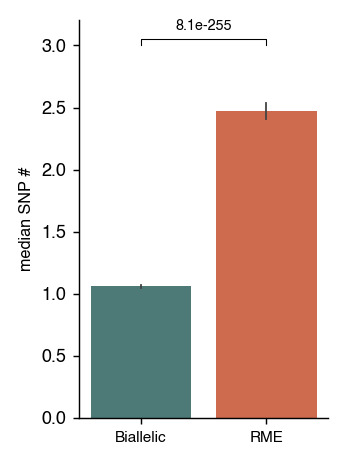

In [33]:
## Plot boxplot of Biallelic vs. RME genes for median TPMs:

f, ax = plt.subplots(figsize=(1.5, 2), tight_layout=True)
sns.despine()

f_oneway = stats.f_oneway(df_protein[df_protein['mosaic_category'] == 'Biallelic']['snps_per_geneLength'], df_protein[df_protein['mosaic_category'] == 'RME']['snps_per_geneLength'])


ax = sns.barplot(x=df_protein['mosaic_category'], y=df_protein['snps_per_geneLength'], data=df_protein[df_protein['mosaic_category'] != 'Unknown'], order=["Biallelic", "RME"], palette=["#46807D","#E35E39"], ci=68, errwidth=1)
ax.plot([0, 0, 1, 1], [3, 3.05, 3.05, 3], lw=0.6, c='k')
ax.text(0.5, 3.1, "%.2g" % f_oneway.pvalue, ha='center', va='bottom', color='k', fontsize=8)
ax.set_ylabel("median SNP #", fontsize=9, fontweight='light')
ax.set_xlabel("")
ax.set_xticklabels(['Biallelic', 'RME'], fontsize=8.5, fontweight='light')

plt.show()

#plt.savefig('../QC_SupplementalFigures/GTEX-ALL_SAMPLES.v8.phASER_WASP.medSNPnum.vs.z-score_barplot.perGeneLength.protein-coding.pdf', transparent=True)
